# Obstacle Detection in Satellite Images

This notebook includes visualization, training, testing and 
evaluation codes for obstacle detection in a rooftop image

1) [Visualisation of Data and Masks](#section1)

2) [Setting up the model](#section2)

3) [Training the model](#section3)

4) [Testing - Detection of Obstacles](#section4)

5) [Evaluation - Mean Average Precision](#section5)

In [1]:
import os,sys,itertools,math,logging,json,re,random,time,datetime,shutil
import tensorflow as tf
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath(r"C:\Users\DELL PC\Mask_RCNN_Reduced")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils,visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import obstacle

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Obstacle trained weights
OBSTACLE_DIR = os.path.join(ROOT_DIR, "")
OBSTACLE_WEIGHTS_PATH = r"C:\Users\DELL PC\Mask_RCNN_Reduced\mask_rcnn_obstacle_0010.h5"  # TODO: update this path

C:\Users\DELL PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='section1'>

# 1) Visualisations

### Configuration of Obstacle class and Loading the dataset 

In [2]:
# Load dataset
config=obstacle.ObstacleConfig()

dataset = obstacle.ObstacleDataset()
dataset.load_obstacle(ROOT_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 50
Class Count: 2
  0. BG                                                
  1. object                                            


### Visualising the annotations in training set

Loading and Displaying random samples along with their masks

Image ID : 15
-----
[1 1 1 1 1 1 1 1]


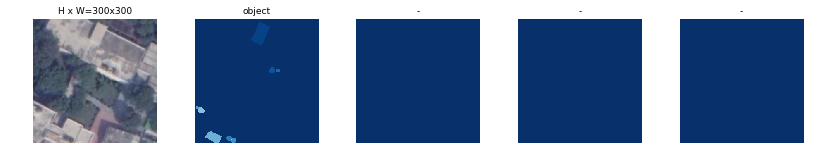

Image ID : 31
-----
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


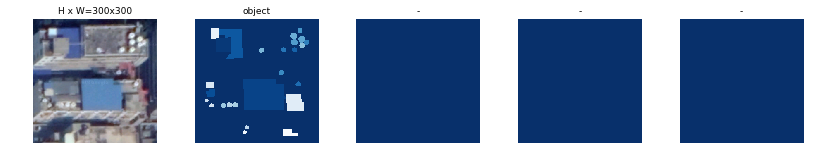

Image ID : 13
-----
[1 1 1 1 1 1 1 1 1 1 1 1]


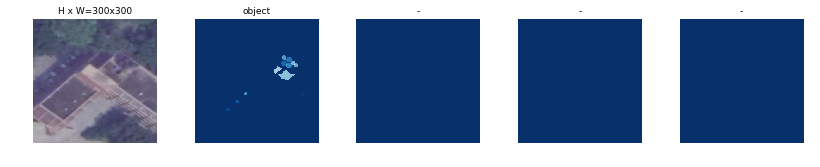

In [3]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    try:
        print('Image ID :',image_id)
        print('-----')
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        print(class_ids)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    except Exception as e:
        print(str(e))
        pass
        print('\n')

### Visualising bounding boxes that are generated through the masks

image_id  2 C:\Users\DELL PC\Mask_RCNN_Reduced\train\faridabad_3.png


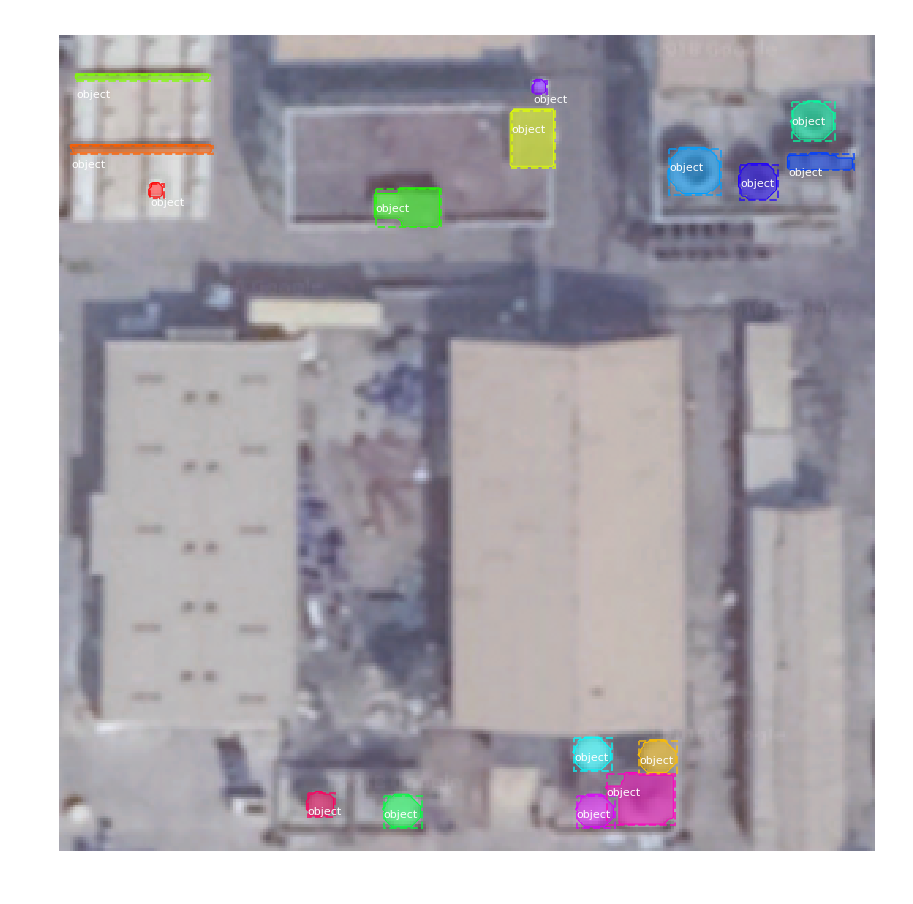

In [4]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats

print("image_id ", image_id, dataset.image_reference(image_id))
#log("image", image)
#log("mask", mask)
#log("class_ids", class_ids)
#log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## After this, multiple operations are performed as described below:

### Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though.
If an image is not square, then zero padding is added at the top/bottom or right/left.

### Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

### Feature Pyramid Network, Region Proposal Network and Anchors

FPN improves the standard feature extraction pyramid by adding a second pyramid that takes the high level features from the first pyramid and passes them down to lower layers. By doing so, it allows features at every level to have access to both, lower and higher level features.

The RPN is a lightweight neural network that scans the image in a sliding-window fashion and finds areas that contain objects.
The regions that the RPN scans over are called anchors, which are boxes distributed over the image area. The RPN doesn’t scan over the image directly, instead, the RPN scans over the backbone feature map. This allows the RPN to reuse the extracted features efficiently and avoid duplicate calculations. 

<a id='section2'>

# 2) Mask RCNN Model

In [5]:
# Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

### Notebook Preferences

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Loading Validation Set

In [8]:
# Load validation dataset
dataset = obstacle.ObstacleDataset()
dataset.load_obstacle(OBSTACLE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 17
Classes: ['BG', 'object']


<a id='section3'>

# Training Process

In [9]:
#Uncomment this cell to train the model
#To be added

### Loading the Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)

In [11]:
# Set path to balloon weights file
try:
    print(model.find_last())
except Exception as e:
    folder_name=str(e).split('\\')[-1]
    PATH=MODEL_DIR+'\\'+folder_name
    shutil.copy(OBSTACLE_WEIGHTS_PATH,PATH)

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\DELL PC\Mask_RCNN_Reduced\logs\obstacle20181101T1731\mask_rcnn_obstacle_0010.h5


<a id='section4'>

## Testing
Detection of obstacles

C:\Users\DELL PC\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image ID: obstacle.37.png (5) C:\Users\DELL PC\Mask_RCNN_Reduced\val\37.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


C:\Users\DELL PC\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:  280.00000  max:  854.00000  int32
gt_mask                  shape: (1024, 1024, 14)      min:    0.00000  max:    1.00000  bool


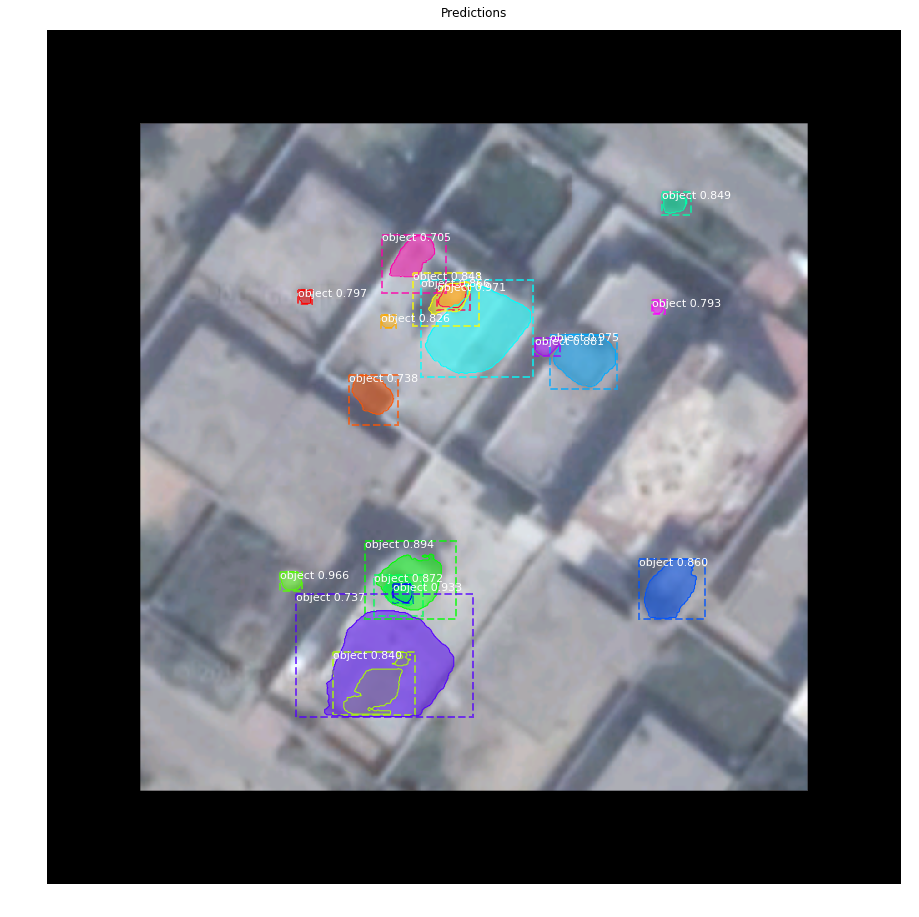

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

<a id='section5'>

# Evaluation using Mean Average Precision

In [13]:
ap = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
print("mAP : ", ap[0])
print("Precision : ", ap[1])
print("Recall : ", ap[2])
print("Overlaps : ", ap[3])

mAP :  0.3901098966598511
Precision :  [1.         1.         1.         1.         1.         1.
 0.83333333 0.71428571 0.625      0.55555556 0.5        0.46153846
 0.46153846 0.46153846 0.42857143 0.4        0.375      0.35294118
 0.33333333 0.        ]
Recall :  [0.         0.07142857 0.14285715 0.21428572 0.2857143  0.35714287
 0.35714287 0.35714287 0.35714287 0.35714287 0.35714287 0.35714287
 0.35714287 0.42857143 0.42857143 0.42857143 0.42857143 0.42857143
 0.42857143 1.        ]
Overlaps :  [[8.2585973e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.9971303e-01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0639927e-01 0.0000000e+00 3.9193731e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0